## SARIMA models
<br>  
**Objectives**  

- Analyze SARIMA models
- Interpret ACF/PACF plots to choose proper SARIMA model
- Fit SARIMA models to observed data
- Develop Python skills

**quick review of lec09**


**quick review of tut09**  
1. check stationary and invertibility    
`ma_model.isstationary`  
`ma_model.isinvertible`
  
  
2. generate ARIMA process    
`sm.tsa.arima_process.ArmaProcess(ar = ar, ma = ma)`   
`arma_model.generate_sample(n_samples)`


3. choose the optimal order   
<span class="girk">#find the best</span>  
`import statsmodels.tsa.stattools as st`  
`st.arma_order_select_ic(df, max_ar, max_ma, ic=['aic'])`    
<span class="girk">#use the one and make the prediction</span>  
<span class="mark">#fit</span>  
`p,q = model.aic_min_order[0], order.aic_min_order[1]`  
`ARIMA(ts_log, order = (p, 1, q)).fit(disp = -1)`   
<span class="mark">#predict</span>  
`best_model.predict(typ = 'levels', dynamic = False)`

### Overview
This tutorial follows the procedure outlined at https://www.otexts.org/fpp/8/7  
For more detailed mathematical explanation, please also refer to https://otexts.com/fpp2/seasonal-arima.html 

Continue with the previous tutorial document, we will discuss the Seasonal ARIMA model. SARIMA models are denoted SARIMA$(p,d,q)(P,D,Q)_m$, where m refers to the number of periods in each season.

<span class="mark">Since SARIMA model is complex to write out directly, we normally use a backshift operator to describe the entire process</span>. For example SARIMA$(1,1,1)(1,1,1)_4$ without a constant is written as:

$\left(1-\phi_{1} B\right)\left(1-\Phi_{1} B^{4}\right)(1-B)\left(1-B^{4}\right) y_{t}=\left(1+\theta_{1} B\right)\left(1+\theta_{1} B^{4}\right) \varepsilon_{t}$

**Can you identify what is the meaning of each factor in the above equation?**
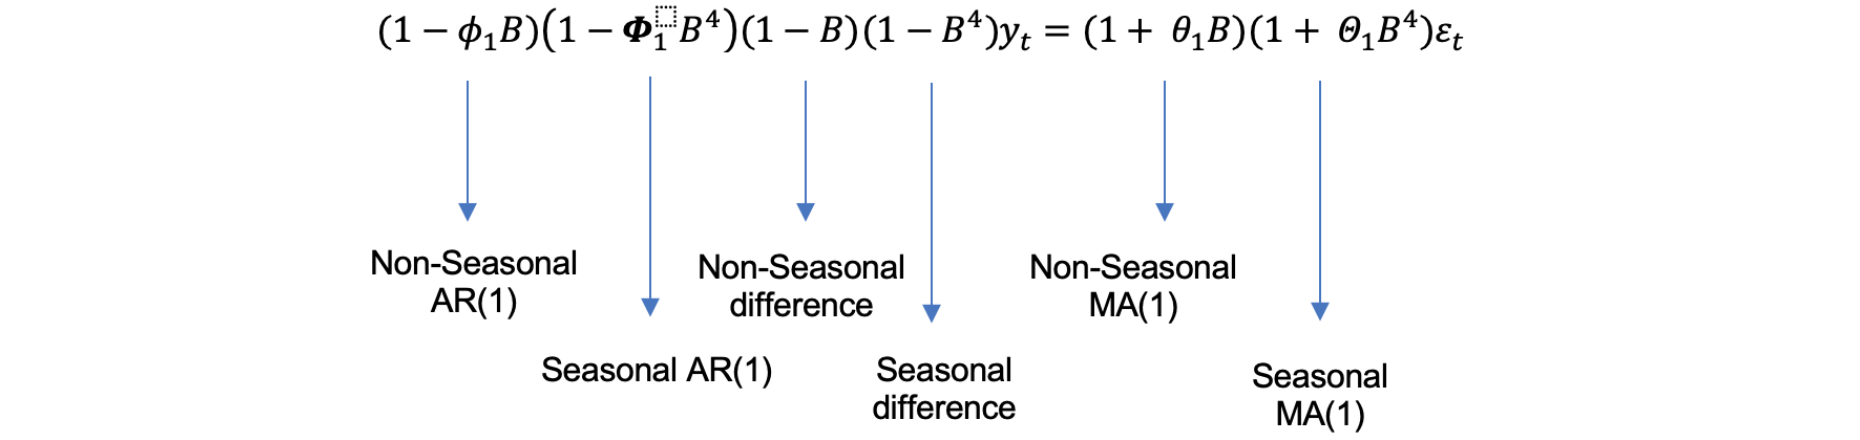

**Why this matter?**

If m=12, can you rewrite the backshift representation for SARIMA$(0,0,1)(0,0,1)_{12}$?  
The non-seasonal $\operatorname{MA}(1)$ is $\left(1+\theta_{1} B\right)$  
The seasonal MA( $(1)$ is $\left(1+\Theta_{1} B^{12}\right)$  
Therefore, the model is $y_{t}=\theta(B) \Theta\left(B^{12}\right) \varepsilon_{t}=\left(1+\theta_{1} B\right)\left(1+\theta_{1} B^{12}\right) \varepsilon_{t}$

When we multiply the 2 polynomials on the right side, we get:

$$y_{t}=\left(1+\theta_{1} B+\theta_{1} B^{12}+\theta_{1} \Theta_{1} B^{13}\right) \varepsilon_{t}$$
$$y_{t}=\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}+\Theta_{1} \varepsilon_{t-12}+\theta_{1} \Theta_{1} \varepsilon_{t-13}$$

**Conclusion 1**: the model has <span class="girk">MA terms at lags 1, 12, and 13</span>.

### Task1: Observe the ACF curve for SARIMA$(0,0,1)(0,0,1)_{12}$

#### Step 1: Set parameters for MA(1) and Seasonal MA(1)

For example, we set $\theta_1$=0.7 for MA(1) and $\Theta_1$=0.8 for Seasonal MA(1). Therefore, the weight for $\epsilon_{t-13}$ is equal to $0.7 \times 0.8$.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import statsmodels as sm 
import statsmodels.api as smt

# ignore warning
import warnings
warnings.simplefilter('ignore')

In [2]:
# set figsize
from pylab import rcParams
rcParams['figure.figsize'] = 16,6

In [11]:
# lag1 = 0.7
# lag2 = lag3 = ... = lag11 = 0
# lag12 = 0.8
# lag13 = 0.7*0.8
maparams = np.array([0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8, 0.8*0.7])
# and lag0 = 1
ma = np.r_[1, maparams]   
# AR(0)
zero_lag = np.array([1])  

#### Step 2. Define the model and plot the ACF curve

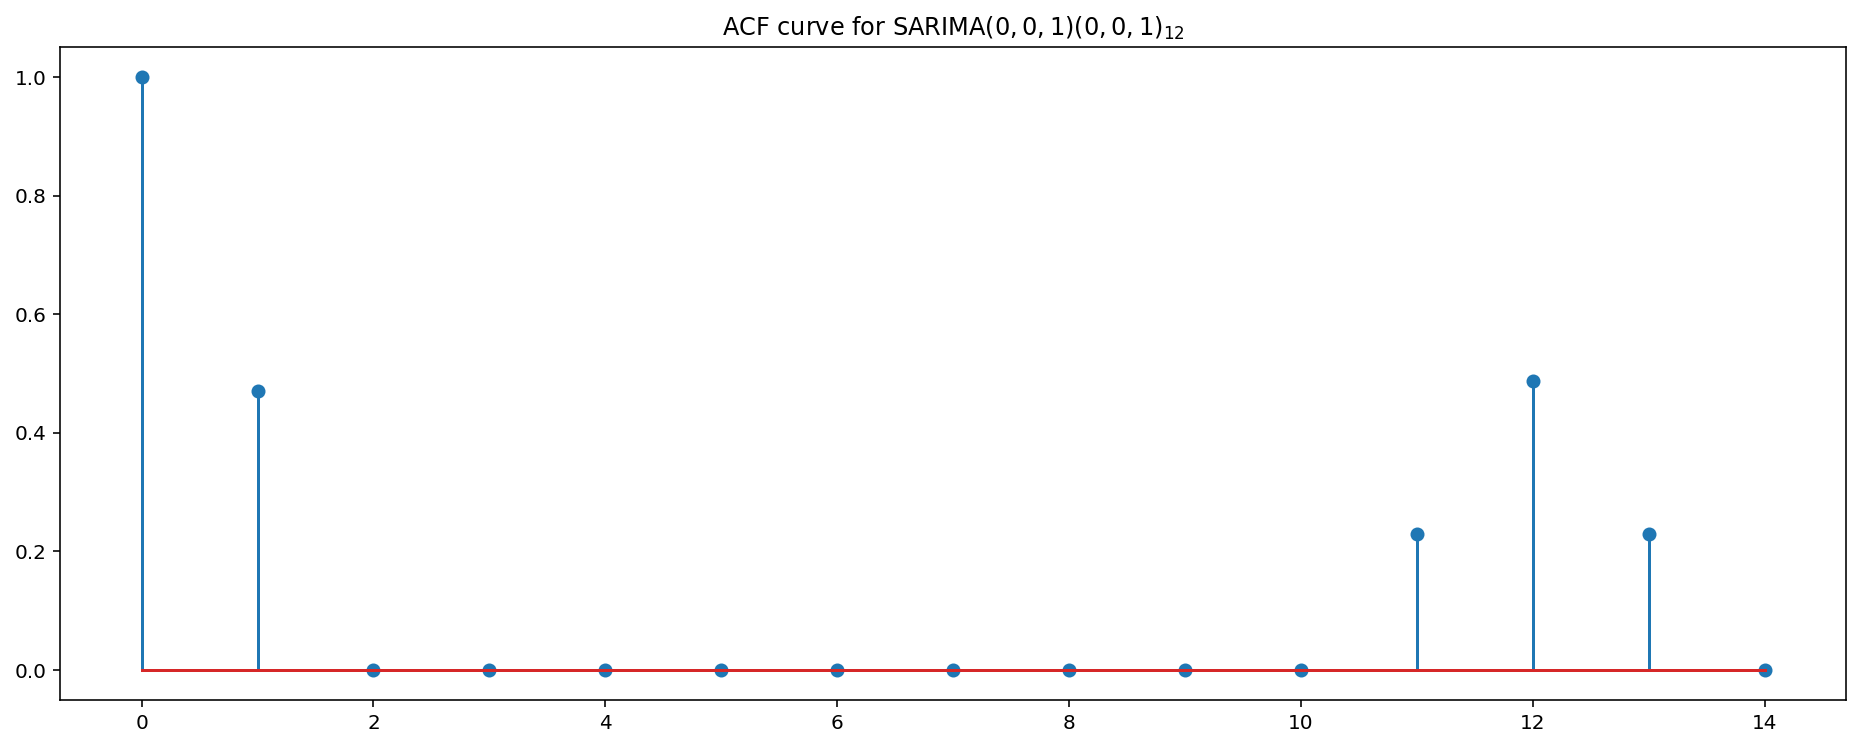

In [12]:
ma_model = sm.tsa.arima_process.ArmaProcess(ar = zero_lag, ma = ma)

# Plot ACF
plt.figure()
plt.stem(ma_model.acf()[:15])
plt.title("ACF curve for SARIMA$(0,0,1)(0,0,1)_{12}$")
plt.show()

Observe the ACF plot, how many peaks we have? What are they?

Recall that SARIMA$(0,0,1)(0,0,1)_{12}$ model is equal to MA terms at lags 1, 12, and 13. This leads many to think that the identifying ACF for the model will have non-zero autocorrelations only at lags 1, 12, and 13. 

(**Optional:**)  
However, from the above ACF plot, we can see $\rho_{11} \neq 0$. Why is this? 

The correlation is defined as Covariance/ product of standard deviations.
The covariance between $y_t$ and $y_{t-11}$ is 
$$\operatorname{Corr}\left(y_{t}, y_{t-11}\right)=E\left(y_{t}-\mu\right)\left(y_{t-11}-\mu\right)$$

In **Conclusion 1**, we have
$$y_{t}=\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}+\Theta_{1} \varepsilon_{t-12}+\theta_{1} \Theta_{1} \varepsilon_{t-13}$$
$$y_{t-11}=\varepsilon_{t-11}+\theta_{1} \varepsilon_{t-1-11}+\Theta_{1} \varepsilon_{t-12-11}+\theta_{1} \Theta_{1} \varepsilon_{t-13-11}$$

The covariance between $y_t$ and $y_{t-11}$ is 

$$\operatorname{Corr}(y_{t}, y_{t-11})=E\left(\varepsilon_{t}+\theta_{1} \varepsilon_{t-1}+\Theta_{1} \varepsilon_{t-12}+\theta_{1} \Theta_{1} \varepsilon_{t-13}-\mu\right)\left(\varepsilon_{t-11}+\theta_{1} \varepsilon_{t-1-11}\right. +\Theta_{1} \varepsilon_{t-12-11}+\theta_{1} \Theta_{1} \varepsilon_{t-13-11}-\mu )$$

Here, $\epsilon$ are independent errors. The expected value of any product involving $\epsilon$’s with <span class="girk">different subscripts</span> will be 0. A covariance between ε’s with the <span class="girk">same subscripts</span> will be the variance of $\epsilon$.

If you inspect all possible products in the above equation, there will be one product with matching subscripts. They have <span class="girk">lag t-12</span>. Thus this expected value (covariance) will be different from 0.

This shows that the lag 11 autocorrelation will be different from 0.  If you look at the more general problem, you can find that only lags 1, 11, 12, and 13 have non-zero autocorrelations for the ARIMA$(0, 0, 1)(0, 0, 1)_{12}$.

For more details, please refer to https://newonlinecourses.science.psu.edu/stat510/node/67/ 


In [ ]:
epsilon_t i.i.d
corr(epsilon_t, epsilon_{t-i}) = 0, as long as i != 0
when i = 0
cov(epsilon_t, epsilon_t) = var(epsilon_t) = sigma^2

**Can you also rewrite the backshift representation for SARIMA$(1,0,0)(1,0,0)_{12}$?**

The non-seasonal $\mathrm{AR}(1)$ is $\phi(B)=\left(1-\phi_{1} B\right)$
The seasonal $A R(1)$ is $\Phi\left(B^{12}\right)=\left(1-\Phi_{1} B^{12}\right)$
Therefore, the model is $\phi(B) \Phi\left(B^{12}\right) y_{t}=\left(1-\phi_{1} B\right)\left(1-\Phi_{1} B^{12}\right) y_{t}=\varepsilon_{t}$

Thus, we will get:
$$\left(1-\phi_{1} B\right)\left(1-\Phi_{1} B^{12}\right) y_{t}=\varepsilon_{t}$$
$$\left(1-\phi_{1} B-\Phi_{1} B^{12}+\phi_{1} \Phi_{1} B^{13}\right) y_{t}=\varepsilon_{t}$$
$$y_{t}-\phi_{1} y_{t-1}-\Phi_{1} y_{t-12}+\phi_{1} \Phi_{1} y_{t-13}=\varepsilon_{t}$$
$$y_{t}=\phi_{1} y_{t-1}+\Phi_{1} y_{t-12}-\phi_{1} \Phi_{1} y_{t-13}+\varepsilon_{t}$$

**Conclusion 2**: the model has AR terms at <span class="girk">lag 1, 12, and 13</span>.

### Task2: Observe the PACF curve for SARIMA$(1,0,0)(1,0,0)_{12}$

#### Step 1: Set parameters for AR(1) and Seasonal AR(1)

For example, we set $\phi_1$=0.7 for AR(1) and $\Phi_1$=0.8 for Seasonal AR(1). Therefore, the weight for $y_{t-13}$ is equal to $-0.7 \times 0.8$.

In [15]:
# lag1 = 0.7
# lag2 = lag3 = ... = lag11 = 0
# lag12 = 0.8
# lag13 = -0.7*0.8   ⚠️negative sign
arparams = np.array([0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8, -0.8*0.7])
# lag0 = 1
ar = np.r_[1, -arparams]   

#### Step 2. Define the model and plot the PACF curve

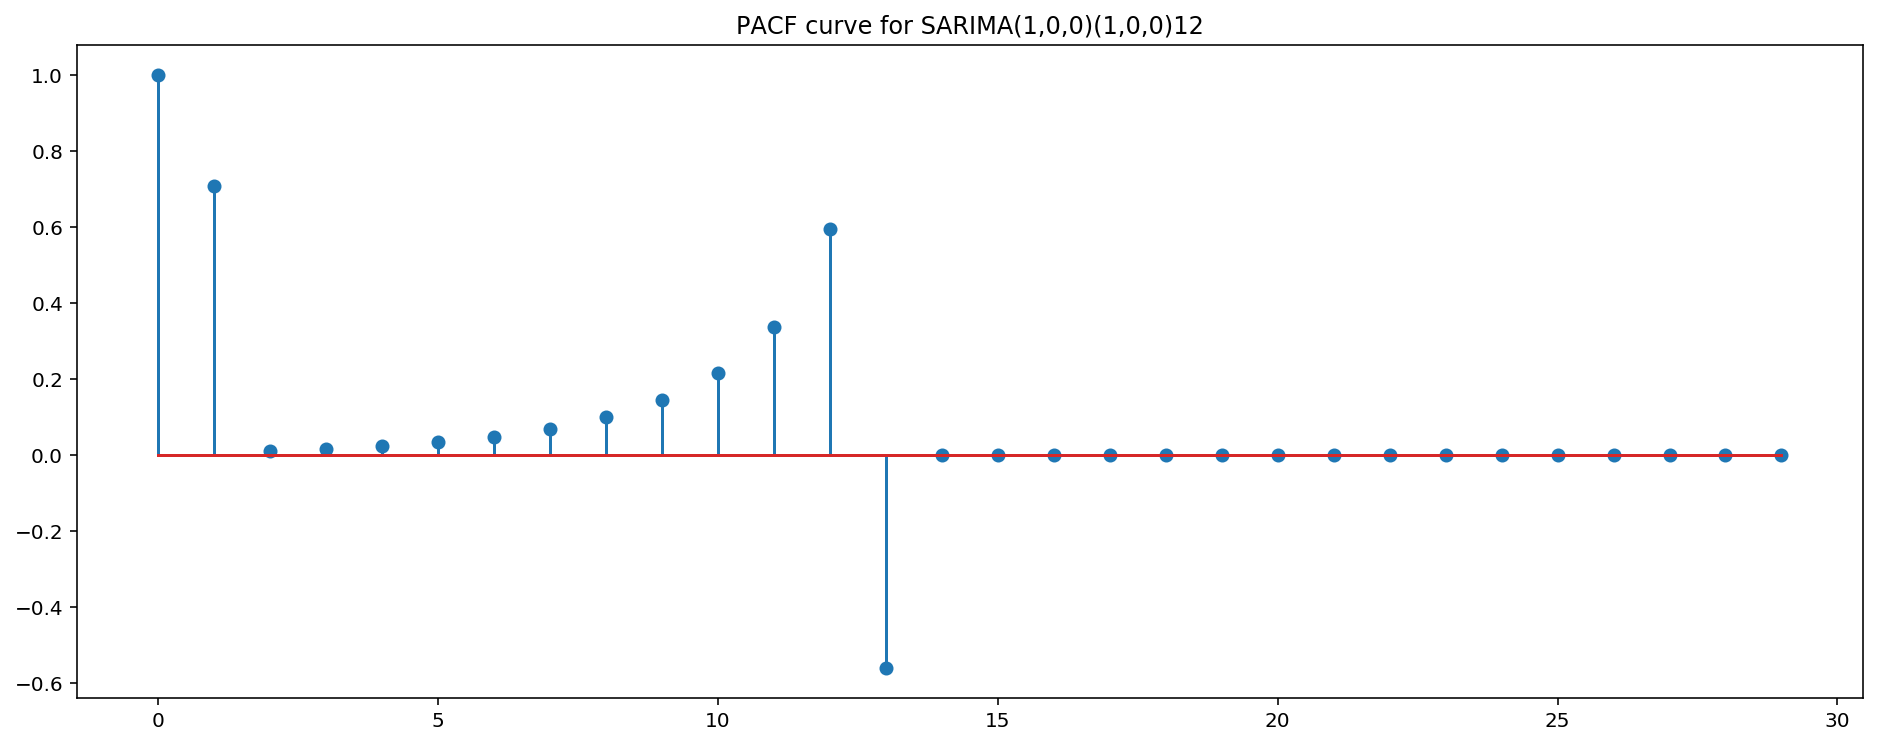

In [16]:
ar_model = sm.tsa.arima_process.ArmaProcess(ar = ar, ma = zero_lag)

plt.figure()
plt.stem(ar_model.pacf()[:30])
plt.title("PACF curve for SARIMA(1,0,0)(1,0,0)12")
plt.show()

**Observe the PACF plot, how many peaks we have? What are they?**

There are distinct spikes at lags 1, 12, and 13 with a bit of action coming before lag 12. Then, it cuts off after lag 13.

Rules for SARIMA model selection from ACF/PACF plots

These are all rule of thumbs, not an exact science for picking the number of each parameters in SARIMA$(p,d,q)(P,D,Q)_m$. The following rules also apply to ARMA and ARIMA models.

<br>

**1.	Identifying the order of differencing:**

**d=0** if the series has no <span class="mark"><span class="mark">visible trend</span></span> or ACF at all lags is low.  
**d≥1** if the series has visible trend or <span class="mark">positive ACF values</span> out to a high number of lags.

**Note 1**:   
if after applying differencing to the series and the ACF at lag 1 is -0.5 or more negative the series may be <span class="girk">over-differenced</span>.  
**Note 2**:   
If you find the best d to be d=1 then the original series has a constant trend. A model with d=2 assumes that the original series has a time-varying trend.

<br>

**2.	Identifying the number of AR and MA terms**

p is equal to the <span class="burk">last lag</span> where the PACF value is above the significance level.  
q is equal to the <span class="burk">last lag</span> where the ACF value is above the significance level.

<br>

**3.	Identifying the seasonal part of the model**:

S is equal to the ACF lag with the highest value (typically at a high lag).  
**D=1** if the series has a <span class="girk">stable seasonal pattern</span> over time.  
**D=0** if the series has an unstable seasonal pattern over time.  
**P≥1** if the <span class="girk">PACF is positive at lag S</span>, else P=0.  
**Q≥1** if the <span class="girk">ACF is negative at lag S</span>, else Q=0.  

**Note 3**:   
In most cases, d+D≤2  
**Note 4**:   
In most cases, P+Q≤2

### Task3: Forecasting with SARIMA
Continue with the task in previous tutorial, we will use SARIMA model to forecast the `AirPassengers.csv` dataset.

Repeat the steps in Step 1-4 in Task 2 of Tutorial 09

In [24]:
import statsmodels as sm 
import statsmodels.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### Step 1: import the data set and check the stationarity

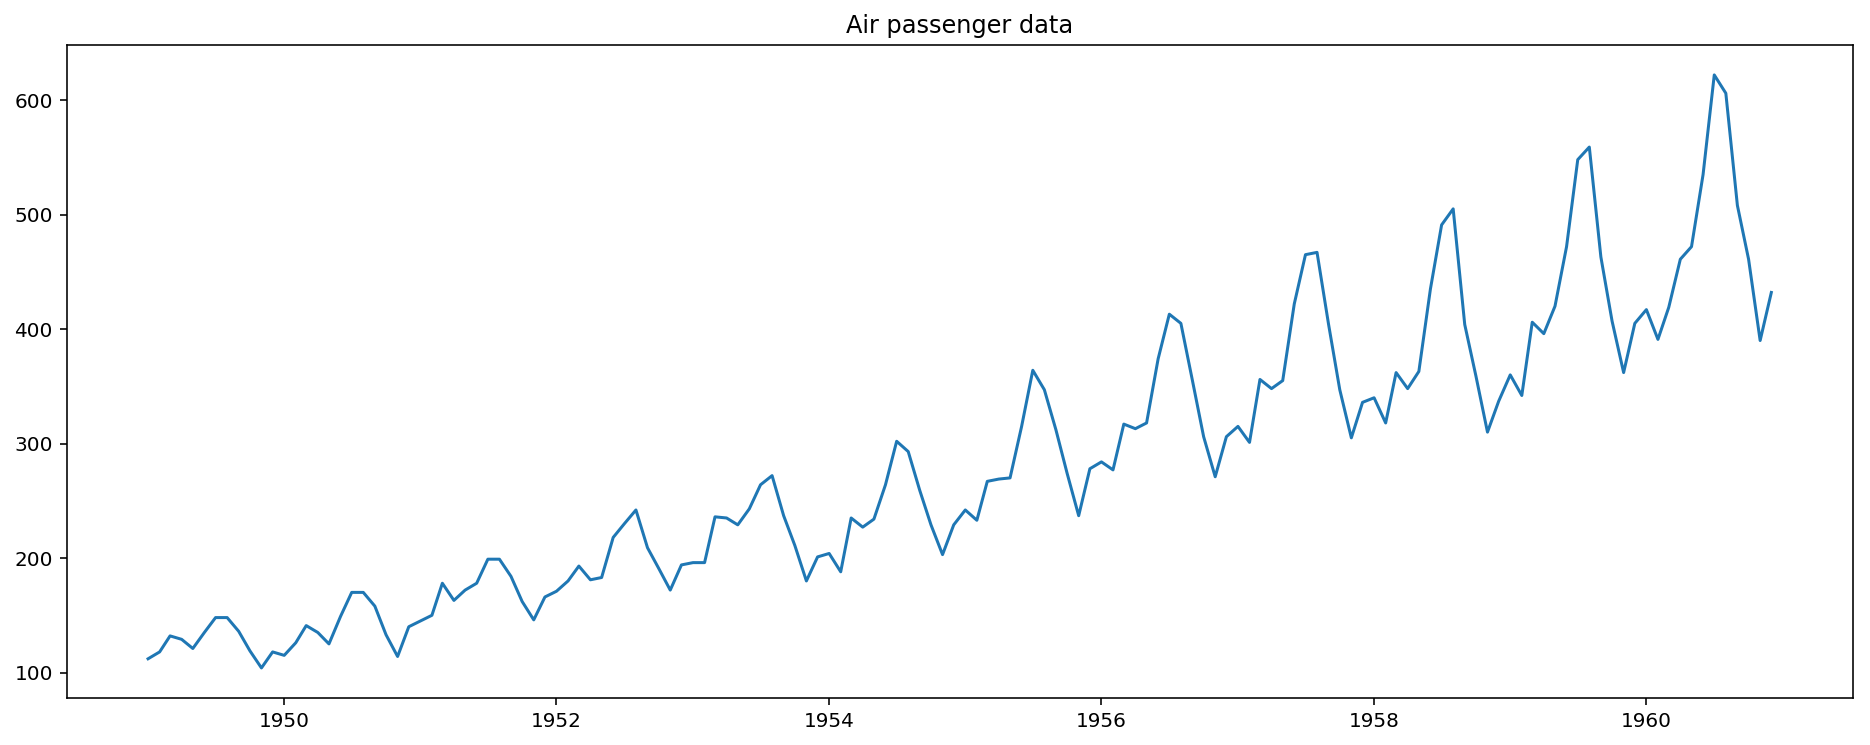

In [25]:
# import the dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
airdata = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)

# define the time series data
ts = airdata['Passengers']

# check the basic features of the data from the visualization results
plt.figure()
plt.plot(ts)
plt.title("Air passenger data"); # don't forget the x- and y-axis names

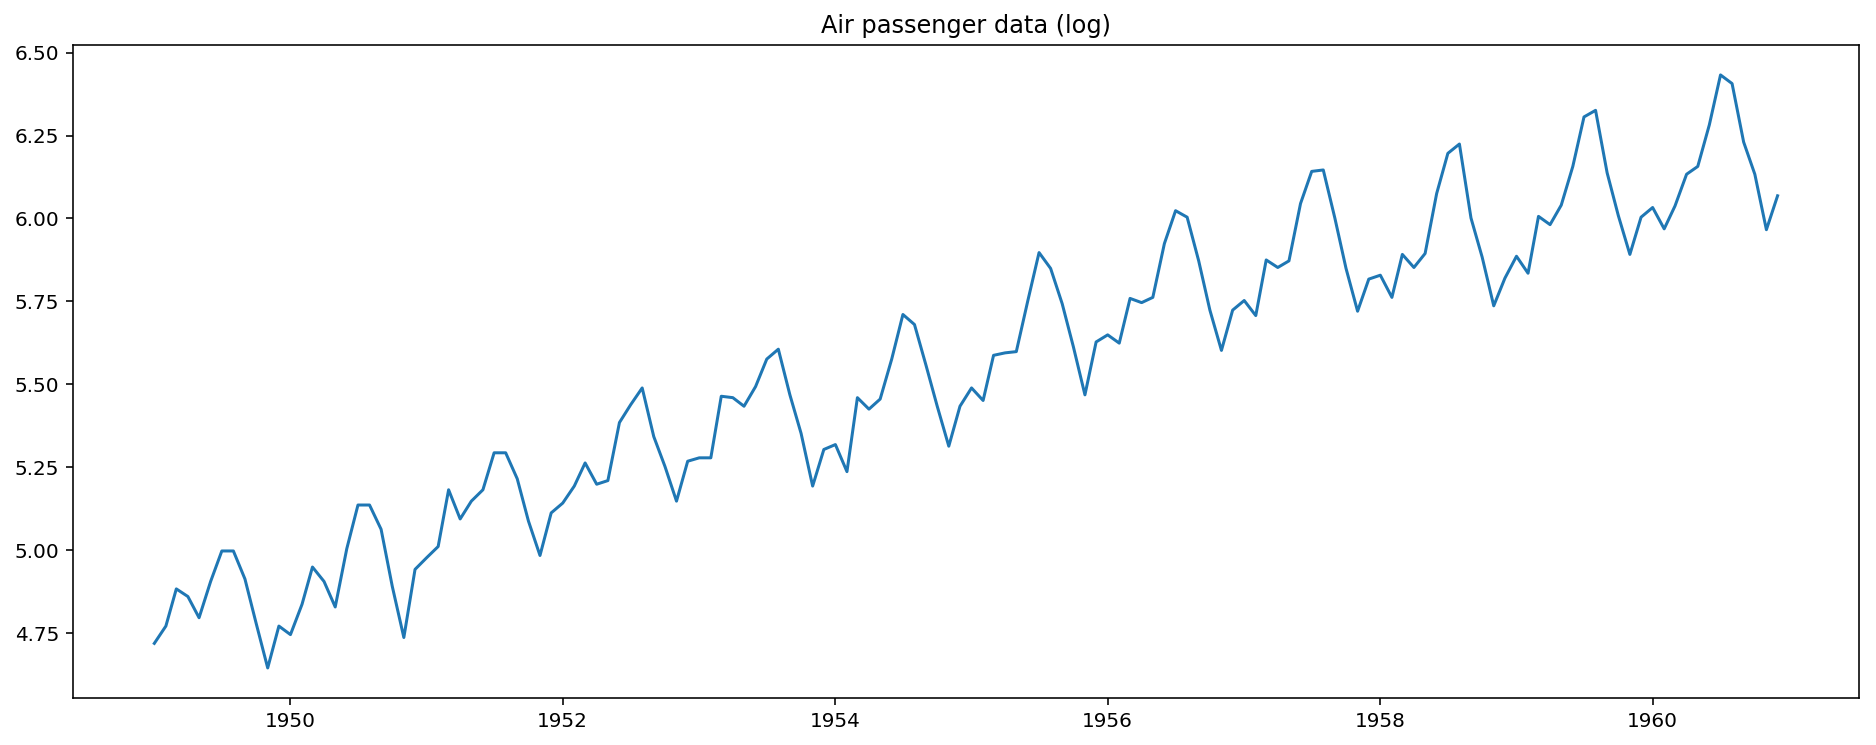

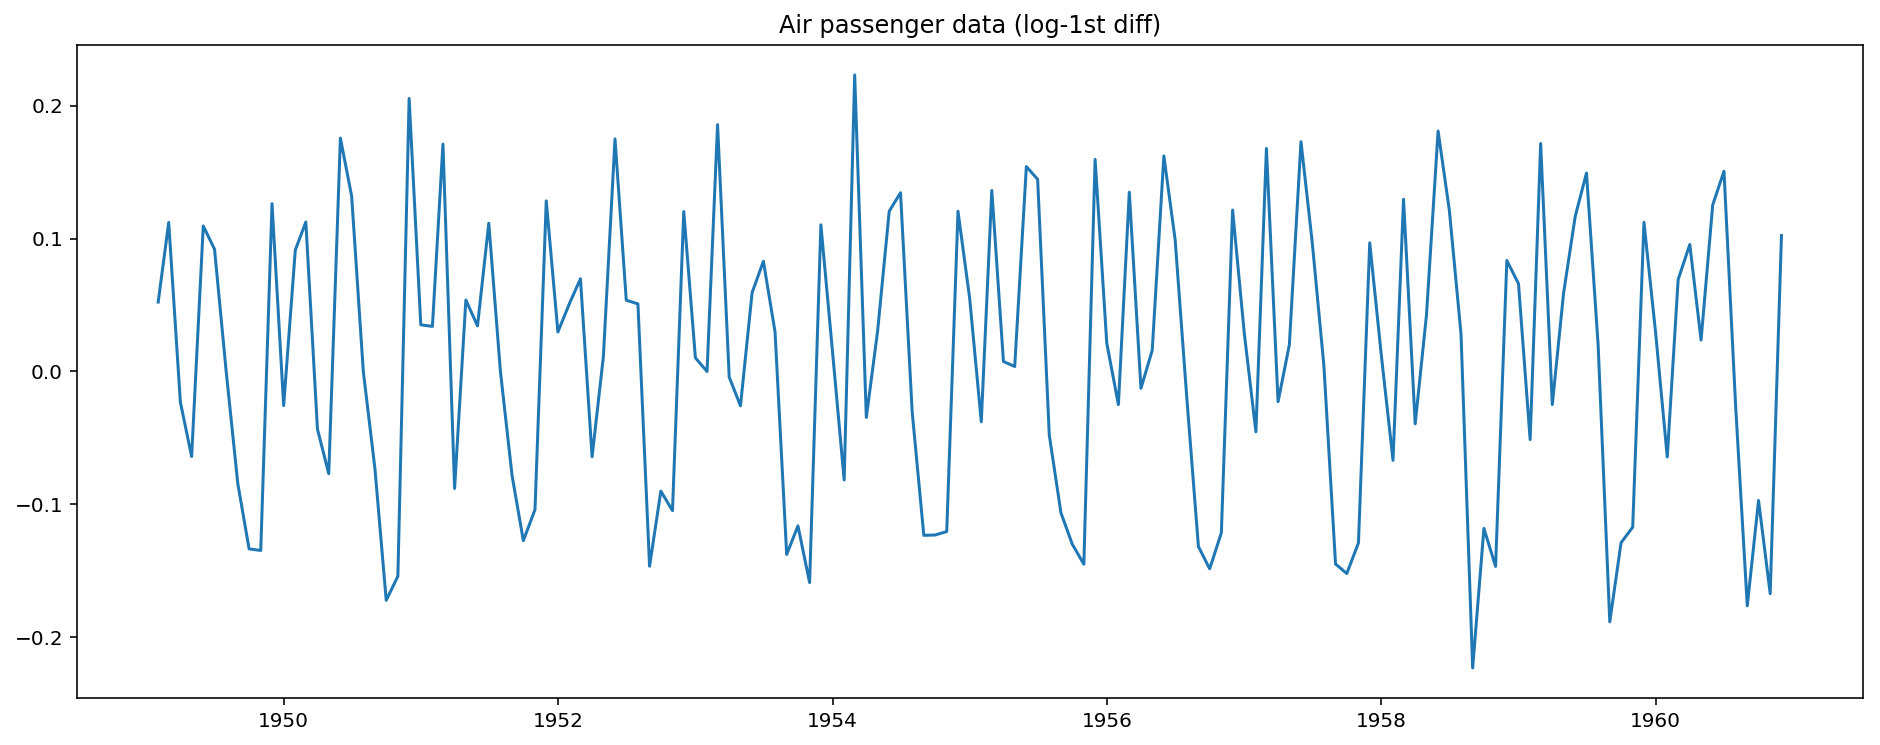

In [26]:
# data pre-processing
# log the data
ts_log = np.log(ts)
plt.figure()
plt.plot(ts_log)
plt.title("Air passenger data (log)");

# take the 1st order diff
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.figure()
plt.plot(ts_log_diff)
plt.title("Air passenger data (log-1st diff)");

#### Step 2: order selection (p, d, q, P, D, Q)

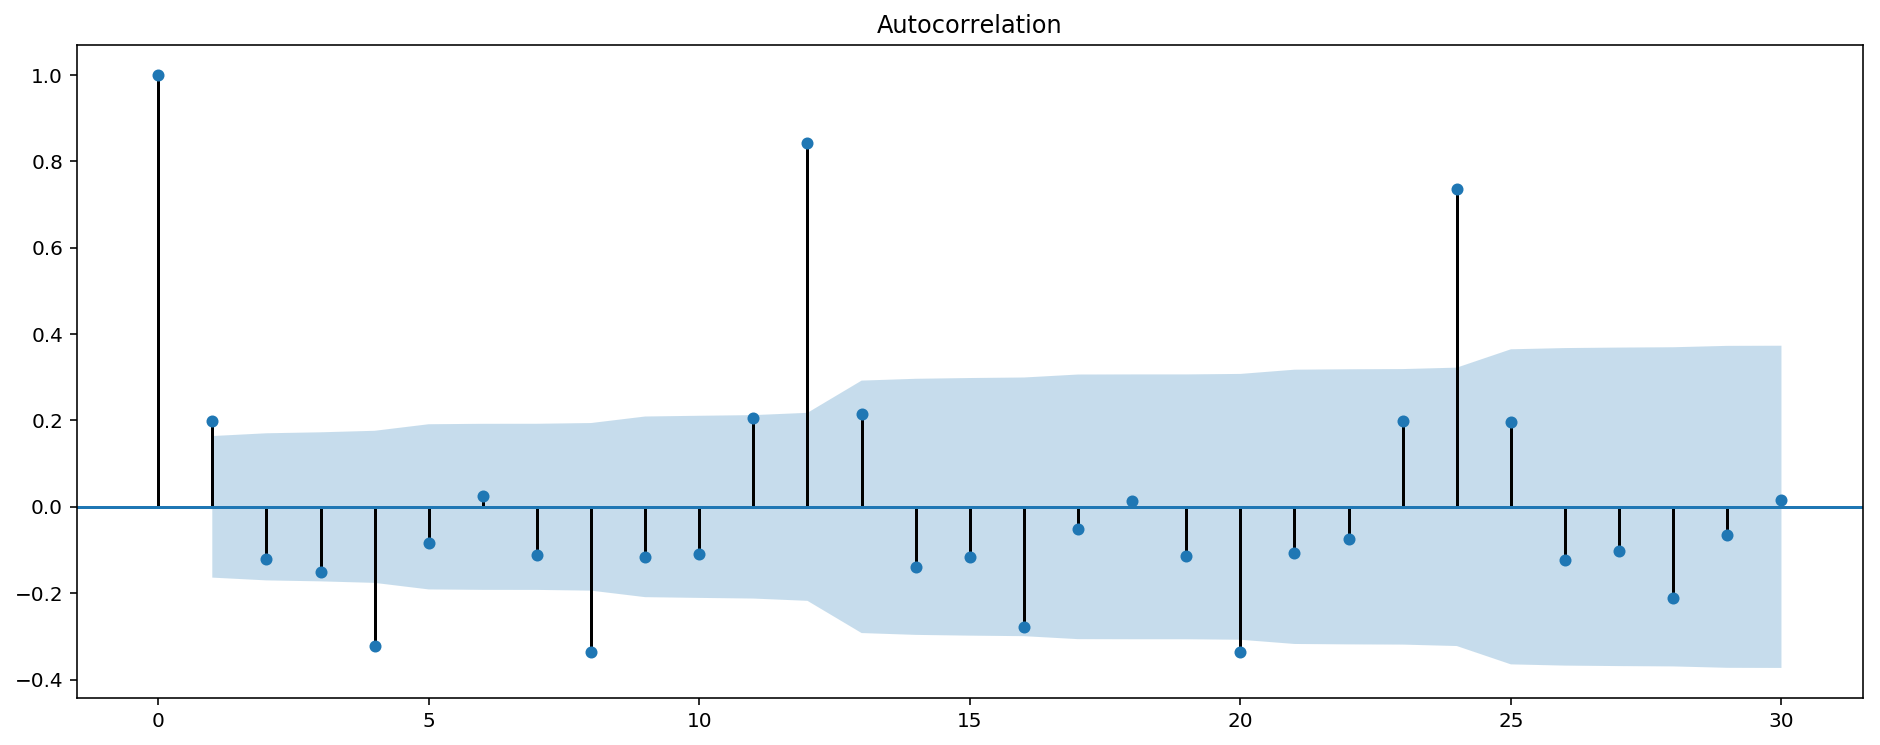

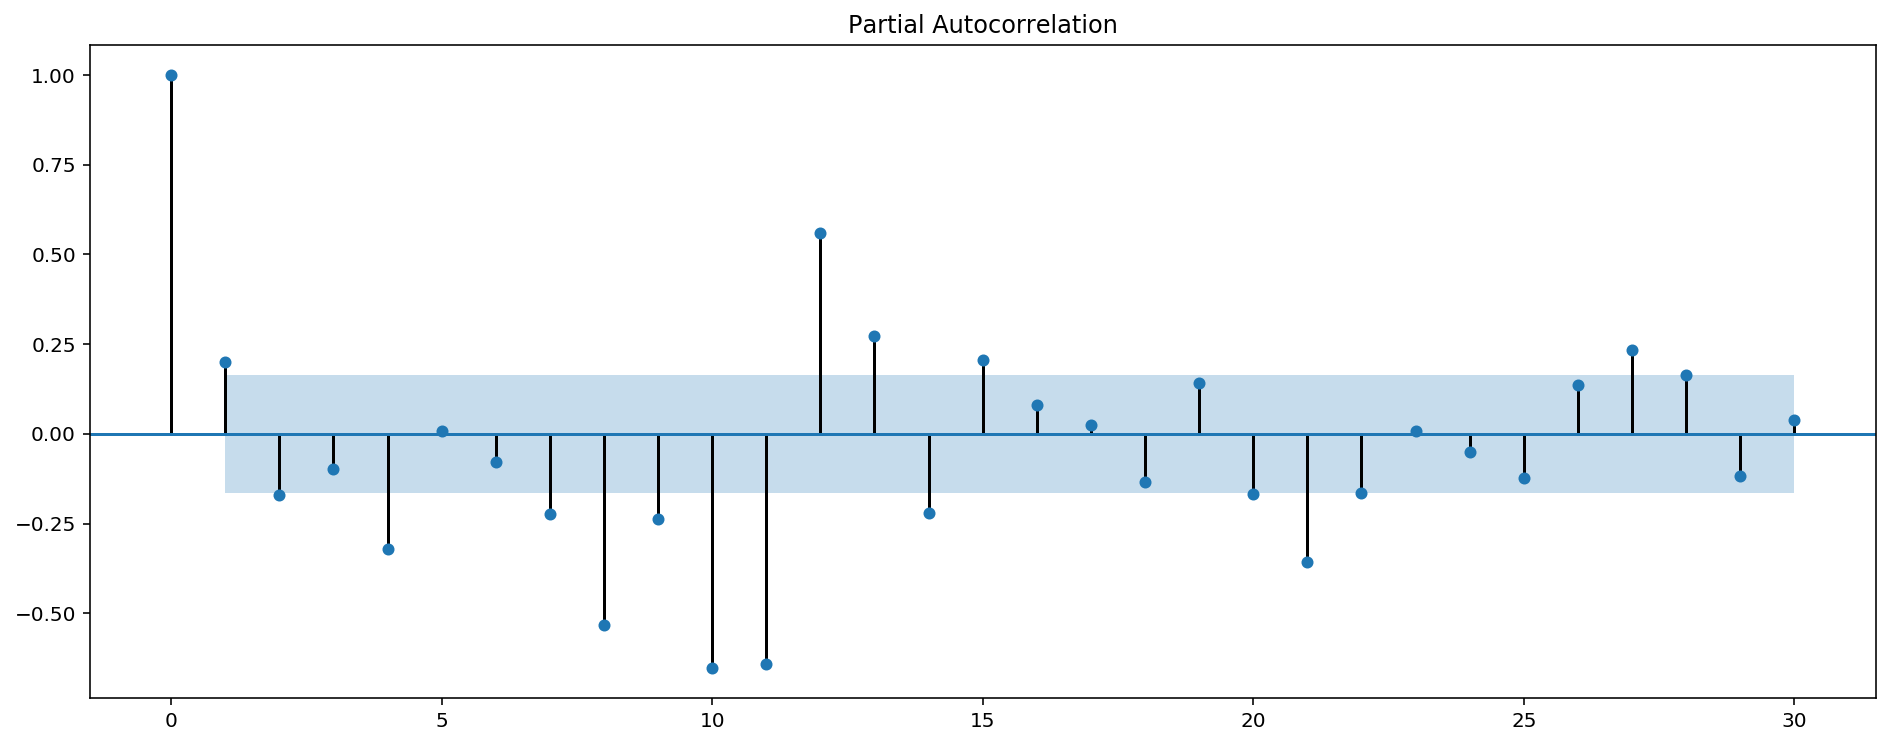

In [27]:
# check the sample acf and pacf plot
smt.graphics.tsa.plot_acf(ts_log_diff, lags = 30, alpha = 0.05);
smt.graphics.tsa.plot_pacf(ts_log_diff, lags =30, alpha = 0.05);

Looking at the ACF and PACF plots of the differenced series we see our first significant cut off at <span class="mark">lag 4 for ACF</span> and at <span class="girk">lag 2 for the PACF</span> which suggest to use p = 2 and q = 4. 

We also have a big value at lag 12 in the ACF plot which suggests our season is m = 12

Since this lag is <span class="mark">positive</span> it suggests <span class="mark">P = 1</span> and Q = 0. 

Since this is a differenced series for SARIMA we set <span class="burk">d = 1</span>, and since the seasonal pattern is not stable over time we set D = 0. 

All together this gives us a SARIMA$(2,1,4)(1,0,0)_{12}$ model. Next we run SARIMA with these values to fit a model on our training data.

#### Step 3: Modeling Training

In [ ]:
train_ratio = 0.7 # use the first 70% data as training set, and the left 30% data as test set
split_point = round(len(ts_log)*train_ratio)
training, testing = ts_log[0:split_point], ts_log[split_point:] # split the data
# we don't use train_test_split, because we don't want to seperate the two set randomly


model = SARIMAX(training, 
                order=(2,1,4),             # p,d,q = 2,1,4
                seasonal_order=(1,0,0,12), # P,D,Q = 1,0,0, period = 12
                enforce_stationarity=False,
                enforce_invertibility=False) 

# fit the SARIMA(4,1,2)(1,0,0)_12 model
model_fit = model.fit(disp = -1)
forecast = model_fit.forecast(len(testing)) # the number of forecasting values = len(testing)


#### Step 4: Result Visualization

Finally, we plot the forecasting results

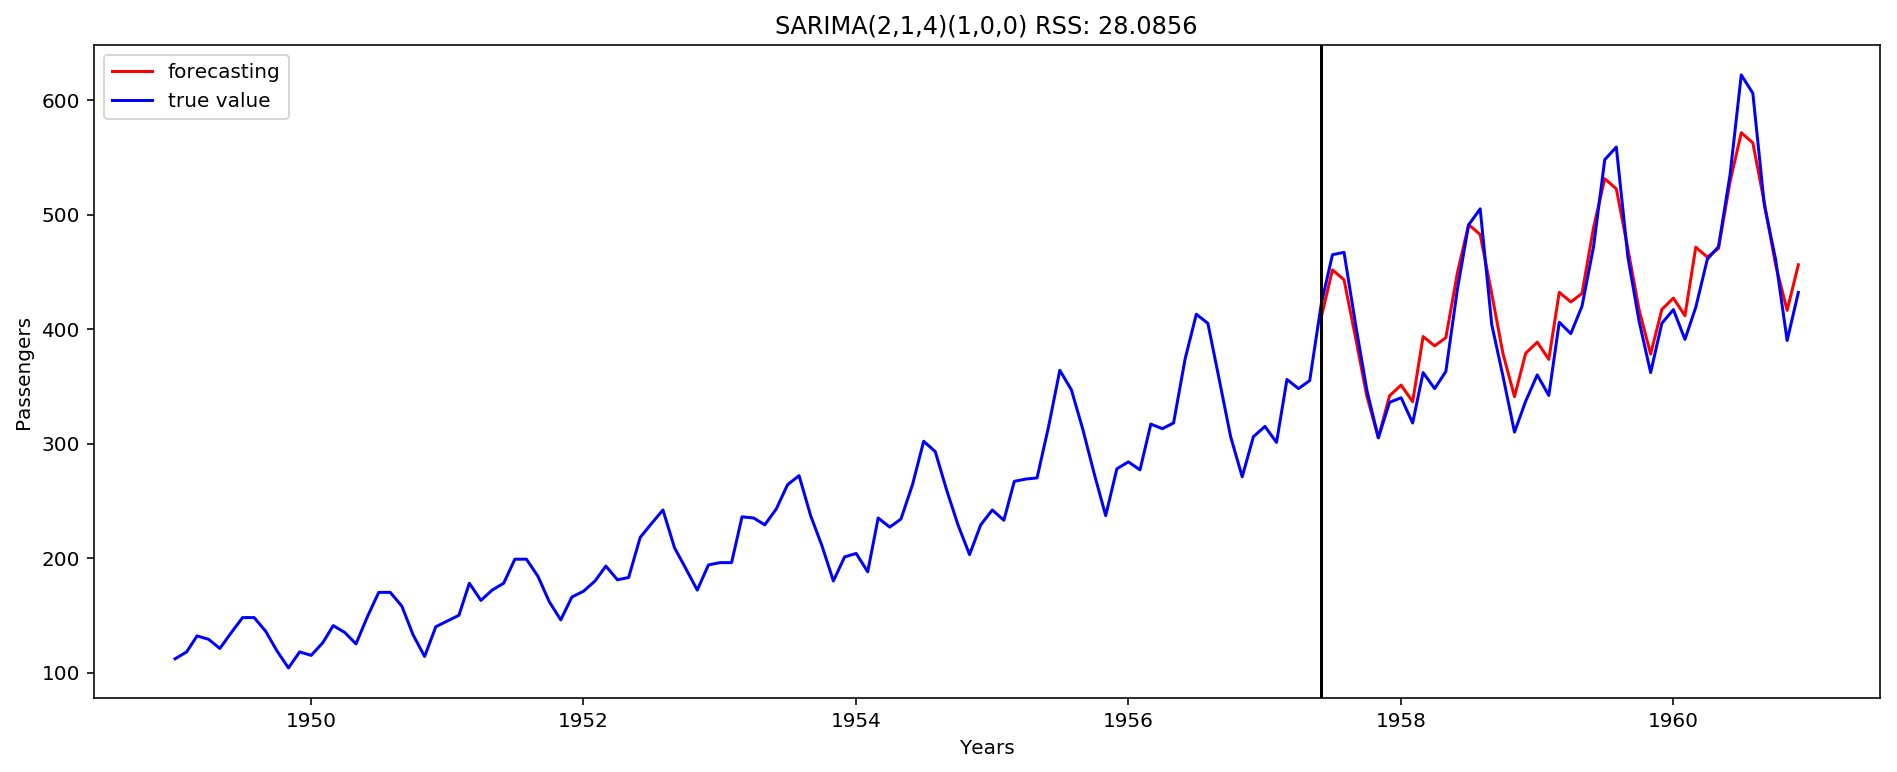

In [33]:
plt.figure()
plt.plot(np.exp(forecast),'r', label = 'forecasting') # use np.exp() to transform back from log(y) values
plt.plot(np.exp(ts_log),'b', label = 'true value')
plt.title('SARIMA(2,1,4)(1,0,0) RSS: %.4f'% sum((model_fit.resid.values)**2))
plt.xlabel("Years")
plt.ylabel("Passengers")
plt.legend()
plt.axvline(x = ts_log.index[split_point], color = 'black'); # boundary of spliting training and test set